# Prediction of Molecular Pathways and Key Mutations

<a href="https://colab.research.google.com/github/TIA-Lab/tiatoolbox/blob/master/examples/07_example_mutationprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://kaggle.com/kernels/welcome?src=https://github.com/TIA-Lab/tiatoolbox/blob/master/examples/06_example_mutationprediction.ipynb" target="_blank"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Kaggle"/></a>

_In order to run this notebook on a Kaggle platform, 1) click on the blue Kaggle badge saying Open in Kaggle 2) click on Settings on the right of the Kaggle screen, 3) log in to your Kaggle account, 4) tick "Internet" checkbox under Settings, to enable necessary downloads._

## About this notebook
This jupyter notebook can be run on any computer with a standard browser and no prior installation of any programming language is required. It can run remotely over the Internet, free of charge, thanks to Google Colaboratory or Kaggle. To connect with Colab or Kaggle, click on one of the two blue checkboxes above. Check that "colab" or "kaggle", as appropriate, appears in the address bar. You can right-click on "Open in Colab" and select "Open in new tab" if the left click does not work for you. Familiarize yourself with the drop-down menus near the top of the window. You can edit the notebook during the session, for example substituting your own image files for the image files used in this demo. Experiment by changing the parameters of functions. It is not possible for an ordinary user to permanently change this version of the notebook on Github, Colab or Kaggle, so you cannot inadvertently mess it up. Use the notebook's File Menu if you wish to save your own (changed) notebook.

To run the notebook on any platform, except for Colab or Kaggle, set up your Python environment, as explained in the 
[README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package) file.

## About this demo
Prediction of molecular pathways and key mutations directly from Haematoxylin and Eosin stained histology images can help bypass additional genetic (e.g., polymerase chain reaction or PCR) or immunohistochemistry (IHC) testing, which can therefore save both money and time.  

In this example notebook, we show how you can use pretrained models to do reproduce the results obtained by Bilal et al. Here, the pipeline utilises a two-stage approach:

- Patch-level tumour segmentation
- Patch-level WSI prediction

In step 1, we use a pretrained tumour segmentation model to identify potentially diagnositc areas. In step 2, we make a task-epcific prediction for each tumour patch. In TIATooolbox, we include models that are capable of predicting:

- Microsatellite instability (MSI)
- Hypermutation density
- Chromosomal instability
- CpG island methylator phenotype (CIMP)-high prediction
- BRAF mutation
- TP53 mutation


### Setting up the environment
The cell below removes some redundant directories of they exist—a previous run may have created them. This cell can be skipped if you are running this notebook for the first time.

In [1]:
![ -d tmp ] && ( echo "deleting tmp directory"; rm -rf tmp )
![ -d sample_tile_results ] && !( echo "deleting 'sample_tile_results' directory"; rm -r sample_tile_results)
![ -d sample_wsi_results ] && ( echo "deleting 'sample_wsi_results' directory"; rm -r sample_wsi_results)
![ -d tissue_mask_results ] && ( echo "deleting 'tissue_mask_results' directory"; rm -r tissue_mask_results)
import warnings
warnings.filterwarnings('ignore')

You can skip the following cell if 1) you are not using the Colab or Kaggle plaforms or 2) you are using Colab or Kaggle and this is not your first run of the notebook in the current session. If you nevertheless run the cell, you may get an error message, but no harm will be done. On Colab or Kaggle the cell installs `tiatoolbox`, and other prerequisite software. Harmless error messages should be ignored. Outside Colab or Kaggle, the notebook expects `tiatoolbox` to already be installed. (See the instructions in [README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package).)

In [2]:
!apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools | tail --line 1
# !pip install git+https://github.com/TissueImageAnalytics/tiatoolbox.git@example-mutation-prediction | tail --line 1 
import os
os.sys.path.append('/home/simon/Desktop/Projects/tiatoolbox')

ON_GPU = False
print('Installation is done.')

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
Installation is done.


**[optional]**: if you are running this example notebook on your system and it is equipped with a Cuda enabled GPU, you can run the following cell to install Cuda enabled version of the torch package to utilize GPU computation and speed up the Tiatoolbox models.

In [3]:
!pip install torch==1.9.1+cu102 torchvision==0.10.1+cu102 -f https://download.pytorch.org/whl/cu102/torch_stable.html --user
ON_GPU = True

Looking in links: https://download.pytorch.org/whl/cu102/torch_stable.html


### Importing related libraries

We import some standard Python modules, and also the Python module `wsireader` (see [details](https://github.com/TIA-Lab/tiatoolbox/blob/master/tiatoolbox/wsicore/wsireader.py)) written by the TIA Centre team.

In [4]:
from tiatoolbox.models.controller.patch_predictor import IOPatchPredictorConfig, CNNPatchPredictor
from tiatoolbox.models.architecture.vanilla import CNNModel
from tiatoolbox.utils.misc import imread, imwrite
from tiatoolbox.wsicore.wsireader import get_wsireader

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, glob

mpl.rcParams['figure.dpi'] = 300 # for high resolution figure in notebook

### Downloading the required files
We download, over the internet, image files used for the purpose of this notebook. In particular, we download a histology tile and a whole slide image of cancerous breast tissue samples to show how semantic segmentation models work. Also, pretrained weights of a Pytorch model and a small WSI are downloaded to illustrate how you can incorporate your own models in the existing Tiatoolbox segmentation tool.
> In Colab, if you click the files icon (see below) in the vertical toolbar on the left hand side then you can see all the files which the code in this notebook can access. The data will appear here when it is downloaded.
>
> 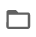

In [5]:
import requests

wsi_file_name = "sample_wsi.svs"
print('Download has started. Please wait...')

# Downloading sample whole-slide image
r = requests.get("https://tiatoolbox.dcs.warwick.ac.uk/sample_wsis/TCGA-3L-AA1B-01Z-00-DX1.8923A151-A690-40B7-9E5A-FCBEDFC2394F.svs")
with open(wsi_file_name, "wb") as f:
    f.write(r.content)

print('Download is complete.')

Download has started. Please wait...
Download is complete.


## Tumour segmentation using TIAToolbox pretrained models
In this section, we will display patch-level tumour segmentation results using a pretrained model used in the original paper by Bilal et al. In particular, this model is a ResNet model with 18 layers (resnet18). Each prediction is made for each input patch within the tissue region that denotes the probability of being tumour. 

> More information on the model and the dataset used for training can be found [here](https://www.thelancet.com/journals/landig/article/PIIS2589-7500(21)00180-1/fulltext) (_Bilal et al., "Development and validation of a weakly supervised deep learning framework to predict the status of molecular pathways and key mutations in colorectal cancer from routine histology images: a retrospective study"_)

In line with the patch prediction model provided in `tiatoolbox`, the tumour segmentation model can be applied to input patches, large images tiles or whole-slide images. In order to replicate the original pipeline, we choose to process a sample whole-slide image.

In [6]:
tumour_predictor = CNNPatchPredictor(
    pretrained_model='resnet18-idars-tumour',
    batch_size=64,
    num_loader_workers=8)

tumour_output = tumour_predictor.predict(
    imgs=[wsi_file_name],
    masks=['dummy_mask.png'],
    mode='wsi',
    return_probabilities=True,
    on_gpu=True)

Download from https://tiatoolbox.dcs.warwick.ac.uk/models/idars/resnet18-idars-tumour.pth
Save to /home/simon/.tiatoolbox/models/resnet18-idars-tumour.pth


100%|#########################################| 110/110 [00:45<00:00,  2.42it/s]


As can be seen above, with just a few lines of code we are capable of performing tumour segmentation on whole-slide images. Here, the patch size used is 512x512, which is selected as the default size in line with that used for training the pretrained model.

You may adjust the `stride_size` to control how much overlap is used between neighbouring predicted patches. Note, if using a small `stride_size` (large overlap), then the model will take longer to process the input.

Below, we show how to merge the output predictions to form a 2-dimensional prediction map, denoting areas predicted as tumour. This prediction map is used in the second step of the pipeline, where we use only patches containing tumour.

In [7]:

overview_resolution = 1.25 # the resolution in which we desire to merge and visualize the patch predictions
overview_unit = "power" # the unit of the `resolution` parameter. Can be "power", "level", "mpp", or "baseline"

# merge predictions to form a 2-dimensional output at the desired resolution
tumour_mask = tumour_predictor.merge_predictions(wsi_file_name, tumour_output[0], resolution=overview_resolution, units=overview_unit)

# the output map will contain values from 0 to 2. 
# 0: background that is not processed, 1: non-tumour prediction and 2 is tumour predictions
tumour_mask = tumour_mask == 2 # binarise the output

Now that we have merged the prediction, let's visuaise the results!

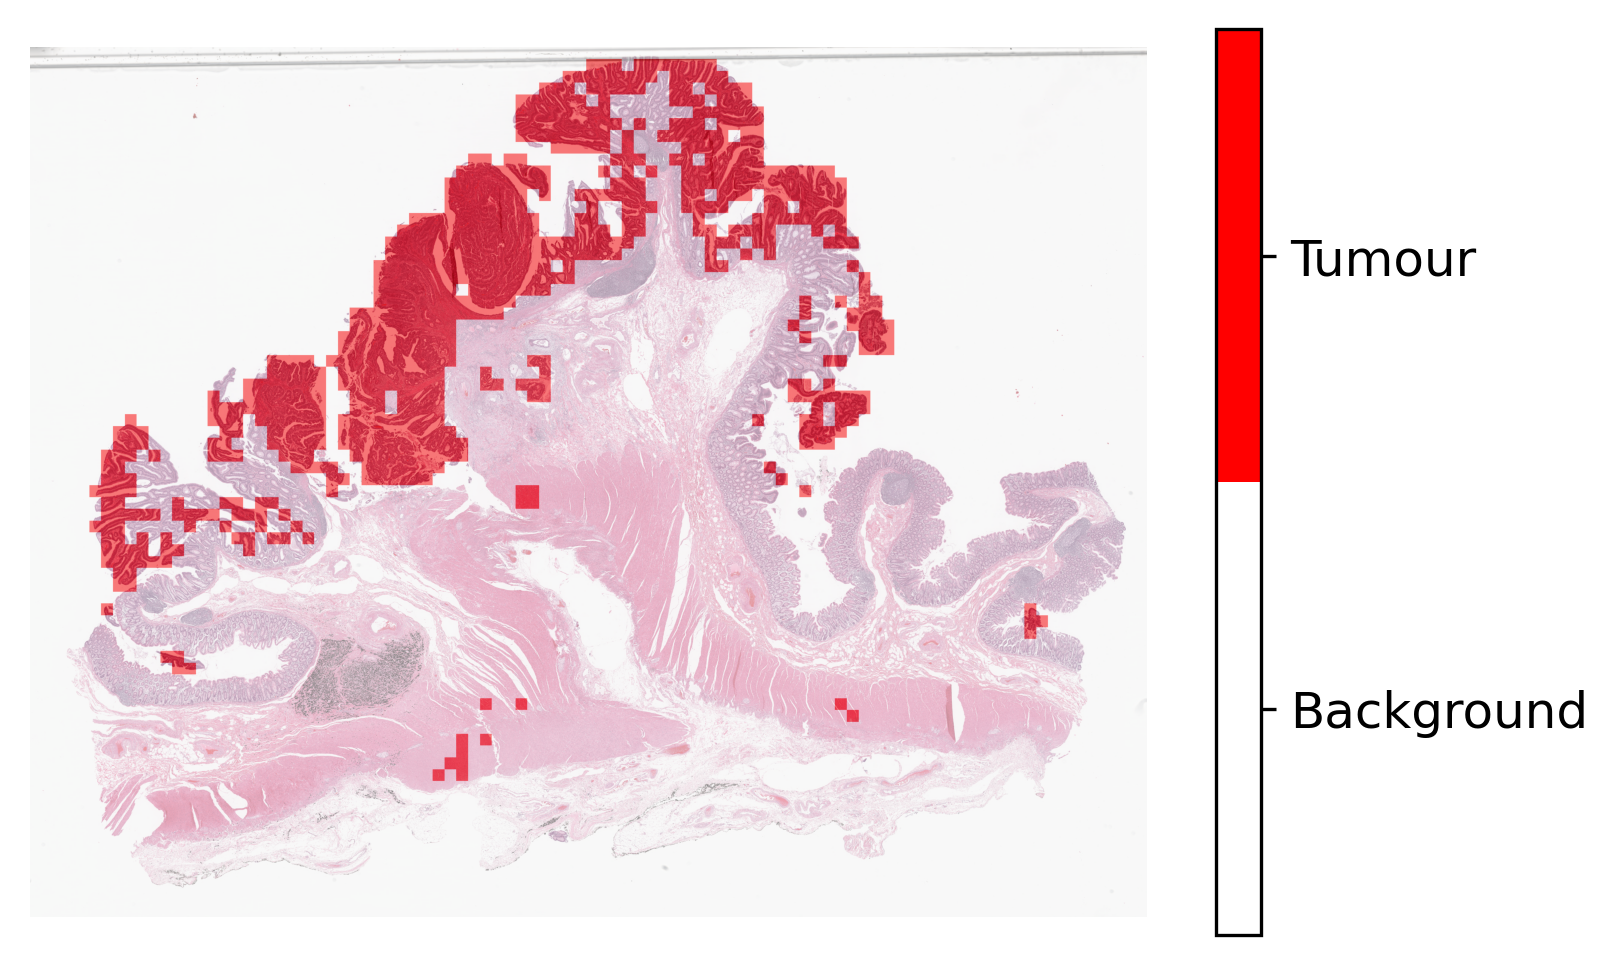

In [8]:
from tiatoolbox.utils.visualization import overlay_patch_prediction

# first read the WSI at a low-resolution. Here, we use the same resolution that was used when merging the patch-level results.
wsi = get_wsireader(wsi_file_name)
wsi_overview = wsi.slide_thumbnail(resolution=overview_resolution, units=overview_unit)

# [Overlay map creation]
# creating label-color dictionary to be fed into `overlay_patch_prediction` function to help generate a color legend
label_dict = {'Background': 0, 'Tumour': 1}
label_color_dict = {}
colors = [[255, 255, 255], [255, 0, 0]]
for class_name, label in label_dict.items():
    label_color_dict[label] = (class_name, np.array(colors[label]))

overlay = overlay_patch_prediction(wsi_overview, tumour_mask, alpha=0.5, label_info=label_color_dict)

## WSI prediction using TIAToolbox pretrained models
Here, we show how one can use a second CNN that takes as input the result obtained from part 1 and gives a prediction for each tumour patch in the input WSI. When conducting the experiments reported in the original paper, 4 fold cross validation was used. Therefore, we supply the weights of each fold for each WSI prediction task. In line with the original paper, all models in the second step were ResNet34.

Near the beginning of the notebook, we mention which prediction tasks we consider. First, we show how we can use the model to predict whether an input WSI is MSI positive.

In [9]:
msi_predictor = CNNPatchPredictor(
    pretrained_model='resnet34-idars-msi-fold1',
    batch_size=64,
    num_loader_workers=8)

msi_output = msi_predictor.predict(
    imgs=[wsi_file_name], 
    masks=['tumour_mask.png'],
    mode='wsi',
    return_probabilities=True, 
    on_gpu=True) 

Download from https://tiatoolbox.dcs.warwick.ac.uk/models/idars/target.jpg
Save to /home/simon/.tiatoolbox/idars_target.jpg
Download from https://tiatoolbox.dcs.warwick.ac.uk/models/idars/resnet34-idars-msi-fold1.pth
Save to /home/simon/.tiatoolbox/models/resnet34-idars-msi-fold1.pth


  0%|                                                   | 0/144 [00:00<?, ?it/s]


Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


  2%|8                                          | 3/144 [00:14<08:58,  3.82s/it]


Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


LinAlgError: Caught LinAlgError in DataLoader worker process 3.
Original Traceback (most recent call last):
  File "/home/simon/.local/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/simon/.local/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/simon/.local/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/simon/Desktop/Projects/tiatoolbox/tiatoolbox/models/dataset/classification.py", line 328, in __getitem__
    patch = self._preproc(patch)
  File "/home/simon/Desktop/Projects/tiatoolbox/tiatoolbox/models/architecture/idars.py", line 109, in preproc
  File "/home/simon/Desktop/Projects/tiatoolbox/tiatoolbox/tools/stainnorm.py", line 108, in transform
    source_concentrations = self.get_concentrations(img, stain_matrix_source)
  File "/home/simon/Desktop/Projects/tiatoolbox/tiatoolbox/tools/stainnorm.py", line 75, in get_concentrations
    x, _, _, _ = np.linalg.lstsq(stain_matrix.T, OD.T, rcond=-1)
  File "<__array_function__ internals>", line 6, in lstsq
  File "/home/simon/anaconda3/envs/tiatoolbox/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 2306, in lstsq
    x, resids, rank, s = gufunc(a, b, rcond, signature=signature, extobj=extobj)
  File "/home/simon/anaconda3/envs/tiatoolbox/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 100, in _raise_linalgerror_lstsq
    raise LinAlgError("SVD did not converge in Linear Least Squares")
numpy.linalg.LinAlgError: SVD did not converge in Linear Least Squares



Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


  2%|8                                          | 3/144 [00:29<08:58,  3.82s/it]

In [10]:
# merge predictions to form a 2-dimensional output at the desired resolution
msi_pmap = msi_predictor.merge_predictions(wsi_file_name, msi_output[0], resolution=overview_resolution, units=overview_unit, return_probmap=True)
msi_pmap = msi_pmap[..., 1] # consider only the positive class (probability of MSI in this case)

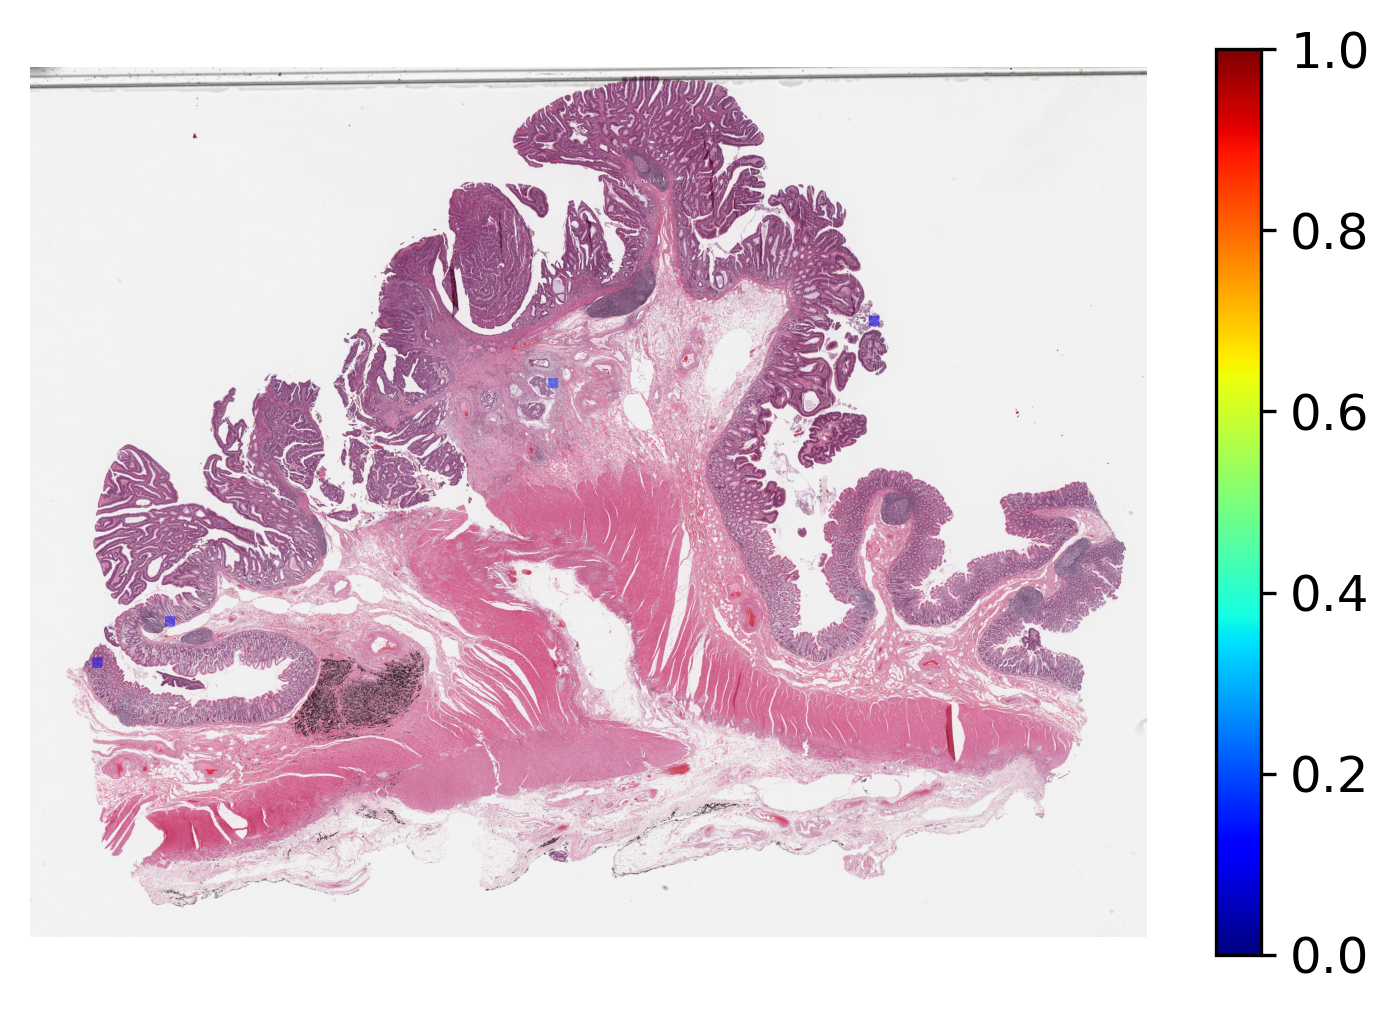

In [17]:
from tiatoolbox.utils.visualization import overlay_patch_probmap

# [Overlay map creation]
# creating label-color dictionary to be fed into `overlay_patch_prediction` function to help generate a color legend
overlay = overlay_patch_probmap(wsi_overview, msi_pmap, alpha=0.5, cutoff=0.1)